### Machine Learning with Diamonds Dataset Notebook
This notebook explores the application of machine learning techniques to the Diamonds dataset is a classic dataset in the field of machine learning, often used for practicing regression and data analysis techniques. It contains information about approximately 54,000 diamonds, including their prices and various attributes.

The dataset provides a rich source of information for understanding the factors that influence diamond prices. It's a great resource for beginners learning data analysis and visualization, as well as for more advanced machine learning tasks like predictive modeling.

The dataset includes the following columns:

- price: The price of the diamond in US dollars ($326 - $18,823)
- carat: The weight of the diamond (0.2 - 5.01)
- cut: The quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- color: Diamond color, from J (worst) to D (best)
- clarity: A measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))   
- x: Length in mm (0 - 10.74)
- y: Width in mm (0 - 58.9)
- z: Depth in mm (0 - 31.8)
- depth: Total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43 - 79)
- table: Width of top of diamond relative to widest point (43 - 95)

Throughout this notebook, we will use HeatWave AutoML to predict the price of a diamond based on its characteristics and prior prices of other diamonds.

### Prerequistises
Install the necessary packages

- mysql-connector-python
- pandas 
- seaborn 
- sshtunnel 
- scikit-learn
- sqlalchemy

In [1]:
import json
import os
import mysql.connector
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sqlalchemy

### Connect to the HeatWave instance
We create a connection to an active [HeatWave](https://www.oracle.com/mysql/) instance using the [MySQL Connector/Python](https://dev.mysql.com/doc/connector-python/en/). We also define an API to execute a SQL query using a cursor, and the result is returned as a Pandas DataFrame. Modify the below variables to point to your HeatWave instance. On AWS, set USE_BASTION to False. On OCI, please create a tunnel on your machine using the below command by substituting the variable with their respective values

ssh -o ServerAliveInterval=60 -i BASTION_PKEY -L LOCAL_PORT:DBSYSTEM_IP:DBSYSTEM_PORT BASTION_USER@BASTION_IP

In [ ]:
BASTION_IP ="ip_address"
BASTION_USER = "opc"
BASTION_PKEY = "private_key_file"
DBSYSTEM_IP = "ip_address"
DBSYSTEM_PORT = 3306
DBSYSTEM_USER = "username"
DBSYSTEM_PASSWORD = "password"
DBSYSTEM_SCHEMA = "mlcorpus"
LOCAL_PORT = 3306
USE_BASTION = True

if USE_BASTION is True:
    DBSYSTEM_IP = "127.0.0.1"
else:
    LOCAL_PORT = DBSYSTEM_PORT

mydb = mysql.connector.connect(
    host=DBSYSTEM_IP,
    port=LOCAL_PORT,
    user=DBSYSTEM_USER,
    password=DBSYSTEM_PASSWORD,
    database=DBSYSTEM_SCHEMA,
    allow_local_infile=True,
    use_pure=True,
    autocommit=True,
)
mycursor = mydb.cursor()


# Helper function to execute SQL queries and return the results as a Pandas DataFrame
def execute_sql(sql: str) -> pd.DataFrame:
    mycursor.execute(sql)
    return pd.DataFrame(mycursor.fetchall(), columns=mycursor.column_names)

 ### Download the Diamonds dataset and load it into Python
 We download the diamonds dataset from [OpenML](https://www.openml.org/search?type=data&status=active&id=42225). We load into Python using Pandas.

In [3]:
# Download the diamonds dataset to a local folder
!curl -O https://www.openml.org/data/get_csv/21792853/dataset.csv

# Create a Pandas dataframe from the data
df = pd.read_csv("dataset.csv", header=0, sep=",", encoding="utf-8")

# Now that we have loaded the data in Python, we don't need the local files anymore
os.remove("dataset.csv")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100 2535k    0 2535k    0     0   132k      0 --:--:--  0:00:19 --:--:--  423k


### Split the data into a training set and an evaluation set
In machine learning, the train-test split is a crucial technique used to evaluate the performance of a model on unseen data. It involves dividing the available dataset into two distinct subsets:   

- Training set: This subset is used to train the machine learning model. The model learns the underlying patterns and relationships in the data by analyzing this set.   
- Test set: This subset is held back and not used during the training process. Once the model is trained, it's applied to the test set to assess its ability to generalize to new, unseen data.

In [4]:
df_train, df_test = train_test_split(
    df, test_size=0.30, random_state=1
)
df_train = df_train.replace({np.nan: "NULL"})
df_test = df_test.replace({np.nan: "NULL"})

 ### Load the Diamonds dataset into a HeatWave table
 We connect to the MySQL database using SQLAlchemy, map Pandas data types to their corresponding MySQL dialects, and writes two DataFrames (df_train and df_test) to separate tables (diamonds_train and diamonds_test) in the database, replacing any existing tables.

In [6]:
# Create a SQLAlchemy engine instance to connect to the MySQL database
sql_engine = sqlalchemy.create_engine(
    f"mysql+mysqlconnector://{DBSYSTEM_USER}:{DBSYSTEM_PASSWORD}@{DBSYSTEM_IP}:{LOCAL_PORT}/{DBSYSTEM_SCHEMA}",
    echo=False,
    echo_pool=False,
    pool_pre_ping=True,
    pool_recycle=3600,
)

# Define a dictionary mapping pandas data types to their corresponding SQLAlchemy dialects
dtype_mapping = {
    "uint64": sqlalchemy.dialects.mysql.INTEGER(unsigned=True),
    "int64": sqlalchemy.dialects.mysql.INTEGER(),
    "float64": sqlalchemy.dialects.mysql.FLOAT(),
    "object": sqlalchemy.dialects.mysql.VARCHAR(length=255),
    "datetime64[ns]": sqlalchemy.dialects.mysql.DATETIME(timezone=False),
    "bool": sqlalchemy.dialects.mysql.TINYINT(),
}
# Prepare the dtype dict for sqlalchemy/pd.DataFrame.to_sql
dtypes = {col: dtype_mapping[str(dtype)] for col, dtype in zip(df.columns, df.dtypes)}

# Write the training DataFrame to the 'diamonds_train' table in the database
df_train.to_sql(
    f"diamonds_train",
    con=sql_engine,
    if_exists="replace",
    dtype=dtypes,
    chunksize=5000,
    index=False,
)
# Write the testing DataFrame to the 'diamonds_test' table in the database
df_test.to_sql(
    f"diamonds_test",
    con=sql_engine,
    if_exists="replace",
    dtype=dtypes,
    chunksize=5000,
    index=False,
)

16182

### Create a HeatWave AutoML model from the Diamonds training dataset
We create a machine learning model on the diamonds dataset using the [ML_TRAIN](https://dev.mysql.com/doc/heatwave/en/mys-hwaml-ml-train.html) API. The column price in the data contains what the price of the diamond is. We specify price as the column that we are trying to learn on, since we need to predict for a new diamond what its price will be. The model handle generated at the end of training is stored in the model variable. We will use this handle to refer to the model in our future interactions

In [7]:
execute_sql("""SET @model = NULL;""")
execute_sql(
    f"""CALL sys.ML_TRAIN('{DBSYSTEM_SCHEMA}.diamonds_train', 'price', JSON_OBJECT('task', 'regression'), @model)"""
)
model = execute_sql("""SELECT @model;""").iat[0,0]
execute_sql(f"""CALL sys.ML_MODEL_LOAD('{model}', NULL)""")

""


### Evaluate the model
We look at the overall performance of the model on unseen data by using the [ML_SCORE](https://dev.mysql.com/doc/heatwave/en/mys-hwaml-ml-score.html) routine to compute the average error in price across predictions. The error metric tells us on average how much the prediction of the model will vary from the actual price on the diamonds_test data.

In [8]:
execute_sql(
    f"""CALL sys.ML_SCORE('{DBSYSTEM_SCHEMA}.diamonds_test', 'price', '{model}', 'neg_mean_absolute_error', @score, NULL);"""
)
score = execute_sql("""SELECT @score;""").iat[0,0]
print(f"The model error is {-score:.2f}")

The model error is 272.63


### Generating predictions to evaluate model performance on unseen test data
We invoke the [ML_PREDICT_TABLE](https://dev.mysql.com/doc/heatwave/en/mys-hwaml-ml-predict-table.html) API to generate prediction for the above model on our test data. The output table contains 2 extra columns 
- Prediction: Contains the actual prediction from the model. This is what the model thinks the customer will do based on the data it has learned from earlier.
- ml_results: This contains more details about the prediction

In [9]:
execute_sql(f"""DROP TABLE IF EXISTS diamonds_test_predictions""")
execute_sql(
    f"""CALL sys.ML_PREDICT_TABLE('{DBSYSTEM_SCHEMA}.diamonds_test', '{model}', '{DBSYSTEM_SCHEMA}.diamonds_test_predictions', NULL)"""
)
df_predictions = execute_sql(f"""SELECT * FROM diamonds_test_predictions""")
execute_sql(f"""DROP TABLE IF EXISTS diamonds_test_predictions""")
df_predictions.head()

,_4aad19ca6e_pk_id,carat,cut,color,clarity,depth,table,price,x,y,z,Prediction,ml_results
0,1,0.33,Ideal,H,SI1,61.7,55.0,564,4.43,4.46,2.74,555.474,"{""predictions"": {""price"": 555.4738572331877}}"
1,2,1.20,Ideal,I,VS2,62.1,57.0,5914,6.78,6.71,4.19,5559.270,"{""predictions"": {""price"": 5559.268379953072}}"
2,3,0.62,Ideal,D,VS1,61.0,57.0,2562,5.51,5.54,3.37,2532.340,"{""predictions"": {""price"": 2532.336104090771}}"
3,4,0.34,Good,H,VS2,63.1,56.0,537,4.41,4.46,2.80,568.279,"{""predictions"": {""price"": 568.278850486865}}"
4,5,1.20,Ideal,E,SI2,62.5,55.0,5964,6.77,6.84,4.25,5949.990,"{""predictions"": {""price"": 5949.994756647619}}"


### Getting a deeper understanding of the model's predictions

Regression models predict on continous values, so we would like to understand how close the model was to predicting the actual price. We use a regression plot, where the X axis shows the actual price of a diamond, and the y axis shows the predicted price for the same diamond. So the closer each point is to the X=Y line across the center, the more accurate the model is. 

<Axes: xlabel='Actual price', ylabel='Predicted price'>

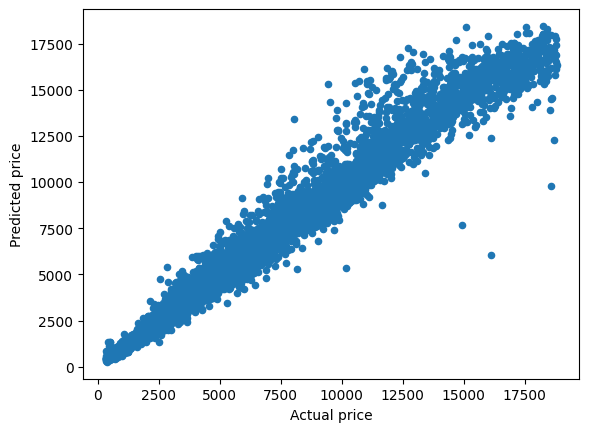

In [10]:
df = pd.DataFrame()
df['Predicted price'] = df_predictions['Prediction']
df['Actual price'] = df_predictions['price'].astype(float)
df.plot.scatter(x='Actual price', y='Predicted price')

### Model explanations

HeatWave AutoML also provides [model explanations](https://dev.mysql.com/doc/heatwave/en/mys-hwaml-model-viewing.html) which provide a global view of which columns contributed the most to create the model. Interesting the carat and the width of the diamond (y) seem to be the most important factors in deciding the price.

<Axes: >

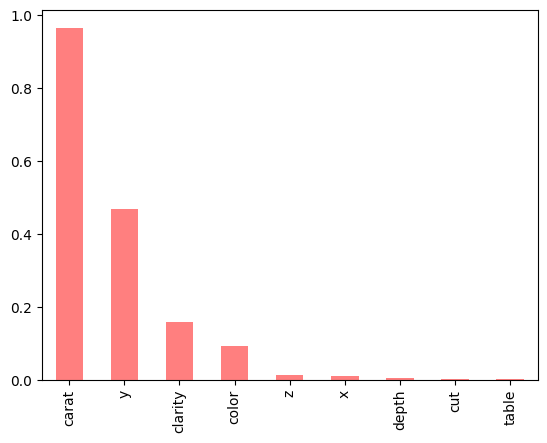

In [11]:
df = execute_sql(
    f"""SELECT model_explanation FROM ML_SCHEMA_{DBSYSTEM_USER}.MODEL_CATALOG WHERE model_handle = '{model}'"""
)
pd.Series(json.loads(df.iat[0,0])["permutation_importance"]).sort_values(
    axis=0, ascending=False
).plot(kind="bar", color="r", alpha=0.5)

We invite you to try [HeatWave AutoML and GenAI](https://www.oracle.com/heatwave/free/). If you’re new to Oracle Cloud Infrastructure, try Oracle Cloud Free Trial, a free 30-day trial with US$300 in credits.